In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

import halotools

In [2]:
import sys 
sys.path.append('MCMC/')
from functions import *

3.0rc1


In [3]:
config_directory = '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/'

config_initial = parse_config(config_directory+'mcmc_config_5.yaml')
config, cosmos_data, sim_data = initial_model(config_initial)

5SHMR+scatter


In [4]:
halo_data = sim_data['halocat'].halo_table

# Chris code

In [21]:
# Given a list of halo masses, find the expected stellar mass
# Does this by guessing stellar masses and plugging them into the inverse
# Scipy is so sick . . .
def f_shmr(log_halo_masses, m1, sm0, beta, delta, gamma):
    if np.max(log_halo_masses) > 1e6:
        raise Exception("You are probably not passing log halo masses!")
    # Function to minimize
    def f(stellar_masses_guess):
        return np.sum(
                np.power(
                    f_shmr_inverse(stellar_masses_guess, m1, sm0, beta, delta, gamma) - log_halo_masses,
                    2,
                )
        )
    # Gradient of the function to minimize
    def f_der(stellar_masses_guess):
        return 2 * (
                (f_shmr_inverse(stellar_masses_guess, m1, sm0, beta, delta, gamma) - log_halo_masses) *
                f_shmr_inverse_der(stellar_masses_guess, sm0, beta, delta, gamma)
        )

    x = scipy.optimize.minimize(
            f,
            log_halo_masses - 2,
            method="CG",
            jac=f_der,
            tol=1e-12, # roughly seems to be as far as we go without loss of precision
    )
    if not x.success:
        raise Exception("Failure to invert {}".format(x.message))
    return x.x
def f_shmr_inverse(log_stellar_masses, m1, sm0, beta, delta, gamma):
    if np.max(log_stellar_masses) > 1e6:
        raise Exception("You are probably not passing log masses!")

    stellar_masses = np.power(10, log_stellar_masses)

    usm = stellar_masses / sm0 # unitless stellar mass is sm / characteristic mass
    log_halo_mass = np.log10(m1) + (beta * np.log10(usm)) + ((np.power(usm, delta)) / (1 + np.power(usm, -gamma))) - 0.5
    return log_halo_mass

# d log10(halo_mass) / d log10(stellar_mass)
# http://www.wolframalpha.com/input/?i=d%2Fdx+B*log10(x%2FS)+%2B+((x%2FS)%5Ed)+%2F+(1+%2B+(x%2FS)%5E-g)+-+0.5
# https://math.stackexchange.com/questions/504997/derivative-with-respect-to-logx
def f_shmr_inverse_der(log_stellar_masses, sm0, beta, delta, gamma):
    if np.max(log_stellar_masses) > 1e6:
        raise Exception("You are probably not passing log masses to der!")

    stellar_masses = np.power(10, log_stellar_masses)
    usm = stellar_masses / sm0 # unitless stellar mass is sm / characteristic mass
    denom = (usm**-gamma) + 1
    return stellar_masses * np.log(10) * (
        (beta / (stellar_masses * np.log(10))) +
        ((delta * np.power(usm, delta - 1)) / (sm0 * denom)) +
        ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))






# Given the b_params for the behroozi functional form, and the halos in the sim
# find the SM for each halo
def get_sm_for_sim(sim_data, b_params, s_params, x_field, sanity=False):
    assert len(b_params) == 5 and len(s_params) == 2

    log_halo_masses = np.log10(sim_data[x_field])
    min_mvir = np.min(log_halo_masses)
    max_mvir = np.max(log_halo_masses)

    sample_halo_masses = np.linspace(min_mvir, max_mvir, num=12)

    try:
        sample_stellar_masses = f_shmr(
            sample_halo_masses,
            10**b_params[0],
            10**b_params[1],
            *b_params[2:])
        
    except Exception as e:
        if e.args[0].startswith("Failure to invert"):
            return np.zeros_like(log_halo_masses)
        raise


    f_mvir_to_sm = scipy.interpolate.interp1d(sample_halo_masses, sample_stellar_masses)

    log_stellar_masses = f_mvir_to_sm(log_halo_masses)
    if not np.all(np.isfinite(log_stellar_masses)):
        print("infinite SM")
        return np.zeros_like(log_stellar_masses)

    # This adds some stochasticity... Ideally we would keep these as a distribution
    # But that is much harder. So we just accept the stochasticity and that the MCMC
    # will take longer to converge

    log_sm_scatter = s_params[0] * log_halo_masses + s_params[1]
    if not np.all(log_sm_scatter > 0):
        print("negative scatter")
        return np.zeros_like(log_stellar_masses)

    log_stellar_masses += np.random.normal(0, log_sm_scatter, size=len(log_sm_scatter))

    if sanity:
        return log_stellar_masses, sample_halo_masses, sample_stellar_masses, f_mvir_to_sm, min_mvir, max_mvir
    else:
        return log_stellar_masses

In [59]:
mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83]
# mass_s_params = [-0.06, 1.08] #chris params
mass_s_params = [-0.2/3., 1.2]  #felipe params
mass_x_field = "halo_mvir"

In [61]:
chris_stellar_masses = get_sm_for_sim(halo_data, mass_b_params, mass_s_params, mass_x_field, sanity=False)

# HALOTOOLS 

In [26]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory

In [62]:
params = mass_s_params + mass_b_params #concatenate
params = [0.4,0.2]+mass_b_params

In [63]:
sim_data['model'] = PrebuiltSubhaloModelFactory('behroozi10', redshift=config['sim_z'],
                                        scatter_abscissa=[12, 15],
                                        scatter_ordinates=[params[0], params[1]])

for i, model_param in enumerate(config['param_labels']):
    sim_data['model'].param_dict[model_param] = params[i]

# set redshift dependence to 0
for i, model_param in enumerate(config['redshift_param_labels']):
    sim_data['model'].param_dict[model_param] = 0

# populate mock
# sim_data['model'].populate_mock(deepcopy(sim_data['halocat']))
sim_data['model'].populate_mock(sim_data['halocat'])

mock_galaxies = sim_data['model'].mock.galaxy_table
mock_galaxies = mock_galaxies['x', 'y', 'z', 'stellar_mass']

In [64]:
halotools_stellar_masses = np.log10(mock_galaxies['stellar_mass'])

# histograms 

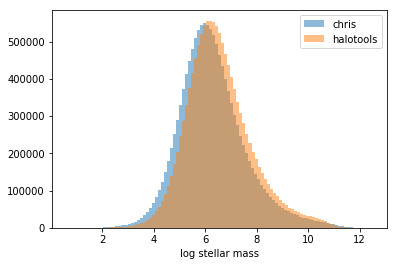

In [65]:
plt.hist(chris_stellar_masses, bins =100, alpha =0.5, label='chris')
plt.hist(halotools_stellar_masses, bins =100, alpha =0.5, label='halotools')

plt.legend()
plt.xlabel('log stellar mass')

plt.show()

In [66]:
print len(halotools_stellar_masses), len(chris_stellar_masses)

12939617 12939617


In [3]:
scatter_params = np.polyfit([12,15],[0.4,0.2],1)

In [5]:
scatter_params[0]

-0.06666666666666685